# AUTOENCODERS

## Introduction

An autoencoder, also known as autoassociator or Diabolo networks, is an artificial neural network employed to recreate the given input. It takes a set of <b>unlabeled</b> inputs, encodes them and then tries to extract the most valuable information from them. They are used for feature extraction, learning generative models of data, dimensionality reduction and can be used for compression. 

Autoencoders are based on Restricted Boltzmann Machines, are employed in some of the largest deep learning applications. They are the building blocks of Deep Belief Networks (DBN).

<img src="https://ibm.box.com/shared/static/xlkv9v7xzxhjww681dq3h1pydxcm4ktp.png" width=400>

## Autoencoder Structure 

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1560249044/deep_autoencoder.png">

An autoencoder can be divided in two parts, the <b>encoder</b> and the <b>decoder</b>.

The encoder needs to compress the representation of an input. In this case we are going to reduce the dimension. The decoder works like encoder network in reverse. It works to recreate the input, as closely as possible. This plays an important role during training, because it forces the autoencoder to select the most important features in the compressed representation.

<h2>Training: Loss function</h2>

An autoencoder uses the Loss function to properly train the network. The Loss function will calculate the differences between our output and the expected results. After that, we can minimize this error with gradient descent. There are more than one type of Loss function, it depends on the type of data.

**Binary Values:**
$$l(f(x)) = - \sum_{k} (x_k log(\hat{x}_k) + (1 - x_k) \log (1 - \hat{x}_k) \ )$$

For binary values, we can use an equation based on the sum of Bernoulli's cross-entropy.  $x_k$ is one of our inputs and $\hat{x}_k$ is the respective output. We use this function so that if $x_k$ equals to one, we want to push $\hat{x}_k$ as close as possible to one. The same if $x_k$ equals to zero. If the value is one, we just need to calculate the first part of the formula, that is, $- x_k log(\hat{x}_k)$. Which, turns out to just calculate $- log(\hat{x}_k)$. And if the value is zero, we need to calculate just the second part, $(1 - x_k) \log (1 - \hat{x}_k) \ )$ - which turns out to be $log (1 - \hat{x}_k) $.

**Real values:**
$$l(f(x)) = - \frac{1}{2}\sum_{k} (\hat{x}_k- x_k \ )^2$$

As the above function would behave badly with inputs that are not 0 or 1, we can use the sum of squared differences for our Loss function.

As it was with the above example, $x_k$ is one of our inputs and $\hat{x}_k$ is the respective output, and we want to make our output as similar as possible to our input.

## MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as kr
%matplotlib inline

Now, let's give the parameters that are going to be used by our NN.

In [2]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
batch_size = 128
epochs = 50

# Network Parameters
hidden_1 = 128 # 1st layer num features.
hidden_2 = 64 # 2nd layer num features (the latent dim).

In [3]:
from tensorflow.keras.datasets import mnist, fashion_mnist

def load_data(choice='mnist', labels=False):
    if choice not in ['mnist', 'fashion_mnist']:
        raise ('Choices are mnist and fashion_mnist')
    
    if choice is 'mnist':
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
    else:
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    X_train, X_test = X_train / 255., X_test / 255.
    X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])
    X_train = X_train.astype(np.float32, copy=False)
    X_test = X_test.astype(np.float32, copy=False)
    
    if labels:
        return (X_train, y_train), (X_test, y_test)
    
    return X_train, X_test


def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        ax[0][i].imshow(np.reshape(y_true[i], (28, 28)), aspect='auto')
        ax[1][i].imshow(np.reshape(y_pred[i], (28, 28)), aspect='auto')
    plt.tight_layout()

In [4]:
def plot_digits(X, y, encoder, batch_size=128):
    """Plots labels and MNIST digits as function of 2D latent vector

    Parameters:
    ----------
    encoder: Model
        A Keras Model instance
    X: np.ndarray
        Test data
    y: np.ndarray
        Test data labels
    batch_size: int
        Prediction batch size
    """
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(X, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y)
    plt.colorbar()
    plt.xlabel("z[0] Latent Dimension")
    plt.ylabel("z[1] Latent Dimension")
    plt.show()
    
    
def generate_manifold(decoder):
    """Generates a manifold of MNIST digits from a random noisy data.

    Parameters:
    ----------
    decoder: Model
        A Keras Model instance
    """
    
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit        
    
    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0] Latent Dimension")
    plt.ylabel("z[1] Latent Dimension")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

Now we need to create our encoder/decoder. For this, we are going to use sigmoidal functions. Sigmoidal functions delivers great results with this type of network. This is due to having a good derivative that is well-suited to backpropagation.

**Encoder**

In [5]:
inputs = kr.Input(shape=(num_features, ))
encoder = kr.layers.Dense(hidden_1, activation='sigmoid')(inputs)
encoder = kr.layers.Dense(hidden_2, activation='sigmoid')(encoder)
encoder_model = kr.Model(inputs, encoder, name='encoder')
encoder_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
Total params: 108,736
Trainable params: 108,736
Non-trainable params: 0
_________________________________________________________________


**Decoder**

In [6]:
latent_dim = kr.Input(shape=(hidden_2, ))
decoder = kr.layers.Dense(hidden_1, activation='sigmoid')(latent_dim)
decoder = kr.layers.Dense(num_features, activation='sigmoid')(decoder)
decoder_model = kr.Model(latent_dim, decoder, name='decoder')
decoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
Total params: 109,456
Trainable params: 109,456
Non-trainable params: 0
_________________________________________________________________


**Autoencoder Model**

In [7]:
outputs = decoder_model(encoder_model(inputs))
mnist_model = kr.Model(inputs, outputs )
mnist_model.compile(optimizer='adam', loss='mse')
mnist_model.summary()

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
encoder (Model)              (None, 64)                108736    
_________________________________________________________________
decoder (Model)              (None, 784)               109456    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [8]:
X_train, X_test = load_data('mnist')
mnist_model.fit(x=X_train, y=X_train, batch_size=batch_size, shuffle=False, epochs=epochs)

11493376/11490434 [==============================] - 0s 0us/step
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0702
Epoch 2/50
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0578
Epoch 3/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0447
Epoch 4/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0389
Epoch 5/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0361
Epoch 6/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0319
Epoch 7/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0287
Epoch 8/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0261
Epoch 9/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0240
Epoch 10/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0220
Epoch 

Let's simply visualize our graphs!

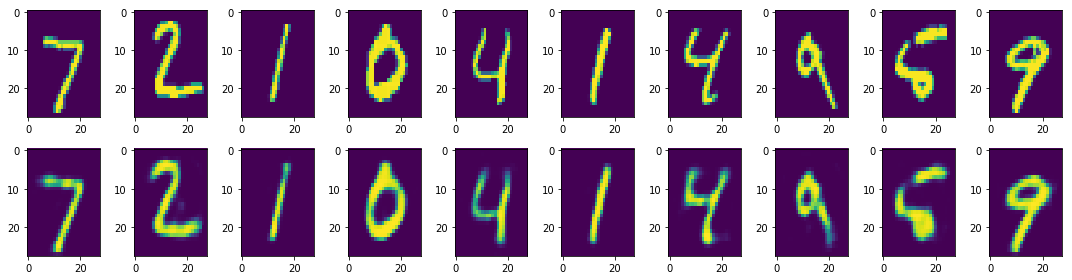

In [9]:
y_true = X_test[:10]
y_pred = mnist_model.predict(y_true)
plot_predictions(y_true, y_pred)

## Fashion MNIST

Let's try our network with fashion mnist to see how well it performs.

In [10]:
# Encoder
inputs = kr.Input(shape=(num_features, ))
encoder = kr.layers.Dense(hidden_1, activation='sigmoid')(inputs)
encoder = kr.layers.Dense(hidden_2, activation='sigmoid')(encoder)
encoder_model = kr.Model(inputs, encoder, name='encoder')
encoder_model.summary()

# Decoder
latent_dim = kr.Input(shape=(hidden_2, ))
decoder = kr.layers.Dense(hidden_1, activation='sigmoid')(latent_dim)
decoder = kr.layers.Dense(num_features, activation='sigmoid')(decoder)
decoder_model = kr.Model(latent_dim, decoder, name='decoder')
decoder_model.summary()

# AE
outputs = decoder_model(encoder_model(inputs))
fmnist_model = kr.Model(inputs, outputs )
fmnist_model.compile(optimizer='adam', loss='mse')
fmnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
Total params: 108,736
Trainable params: 108,736
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dens

In [11]:
X_train, X_test = load_data('fashion_mnist')
fmnist_model.fit(x=X_train, y=X_train, batch_size=batch_size, shuffle=False, epochs=epochs)

4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/50
60000/60000 [==============================] - 2s 25us/sample - loss: 0.0635
Epoch 2/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0377
Epoch 3/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0289
Epoch 4/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0249
Epoch 5/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0231
Epoch 6/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0218
Epoch 7/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0206
Epoch 8/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0196
Epoch 9/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0188
Epoch 10/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0180
Epoch 11/50
60000/60000 [==============================]

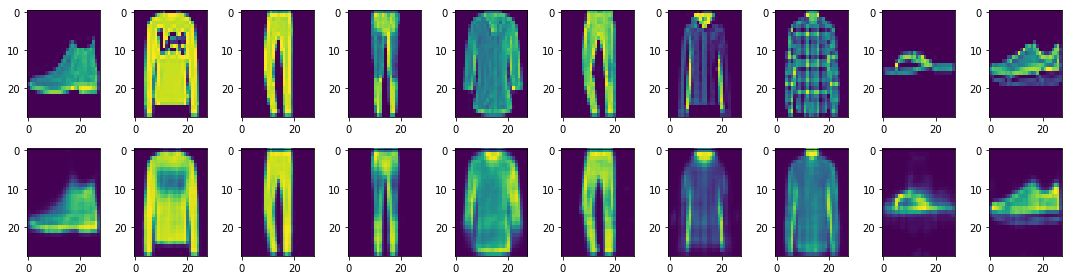

In [12]:
y_true = X_test[:10]
y_pred = fmnist_model.predict(y_true)
plot_predictions(y_true, y_pred)

As can be seen construction was okay not perfect due to some noise in the images. Increasing layer sizes may help.

## Variational Autoencoder

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1560249262/vae-gaussian.png">

We're trying to build a generative model here, not just a fuzzy data structure that can "memorize" images. We can't generate anything yet, since we don't know how to create latent vectors other than encoding them from images.

There's a simple solution here. We add a constraint on the encoding network, that forces it to generate latent vectors that roughly follow a unit gaussian distribution. It is this constraint that separates a variational autoencoder from a standard one.

Generating new images is now easy: all we need to do is sample a latent vector from the unit gaussian and pass it into the decoder.

In practice, there's a tradeoff between how accurate our network can be and how close its latent variables can match the unit gaussian distribution.

We let the network decide this itself. For our loss term, we sum up two separate losses: the generative loss, which is a mean squared error that measures how accurately the network reconstructed the images, and a latent loss, which is the KL divergence that measures how closely the latent variables match a unit gaussian. [ref](http://kvfrans.com/variational-autoencoders-explained/)

In [13]:
def sampling(args):
    """Reparameterization trick. Instead of sampling from Q(z|X), 
    sample eps = N(0,I) z = z_mean + sqrt(var)*eps.

    Parameters:
    -----------
    args: list of Tensors
        Mean and log of variance of Q(z|X)

    Returns
    -------
    z: Tensor
        Sampled latent vector
    """

    z_mean, z_log_var = args
    eps = tf.random_normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z

In [14]:
hidden_dim = 512
latent_dim = 2  # The bigger this is, more accurate the network is but 2 is for illustration purposes.

**Encoder**

In [15]:
inputs = kr.layers.Input(shape=(num_features, ), name='input')
x = kr.layers.Dense(hidden_dim, activation='relu')(inputs)
z_mean = kr.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = kr.layers.Dense(latent_dim, name='z_log_var')(x)

**Sampling Layer**  
Use reparameterization trick to push the sampling out as input

In [16]:
z = kr.layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = kr.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 512)          401920      input[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_8[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_8[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

**Decoder**

In [17]:
latent_inputs = kr.layers.Input(shape=(latent_dim,), name='z_sampling')
x = kr.layers.Dense(hidden_dim, activation='relu')(latent_inputs)
outputs = kr.layers.Dense(num_features, activation='sigmoid')(x)

# instantiate decoder model
decoder = kr.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_10 (Dense)             (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [18]:
# # VAE model = encoder + decoder
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = kr.Model(inputs, outputs, name='vae')

**Define VAE Loss**

In [19]:
# Reconstruction loss
reconstruction_loss = tf.losses.mean_squared_error(inputs, outputs)
reconstruction_loss = reconstruction_loss * num_features

# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [20]:
(X_train, _),  (X_test, y) = load_data('mnist', labels=True)
vae.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 35us/sample - loss: 51.7375 - val_loss: 44.1708
Epoch 2/50
60000/60000 [==============================] - 2s 25us/sample - loss: 43.3303 - val_loss: 42.5126
Epoch 3/50
60000/60000 [==============================] - 2s 25us/sample - loss: 42.3778 - val_loss: 41.8025
Epoch 4/50
60000/60000 [==============================] - 2s 26us/sample - loss: 41.7491 - val_loss: 41.2357
Epoch 5/50
60000/60000 [==============================] - 2s 26us/sample - loss: 41.2249 - val_loss: 40.7765
Epoch 6/50
60000/60000 [==============================] - 2s 25us/sample - loss: 40.7972 - val_loss: 40.4082
Epoch 7/50
60000/60000 [==============================] - 2s 25us/sample - loss: 40.4701 - val_loss: 40.0891
Epoch 8/50
60000/60000 [==============================] - 2s 25us/sample - loss: 40.1675 - val_loss: 40.0527
Epoch 9/50
60000/60000 [==============================] - 2s 26us/sample - los

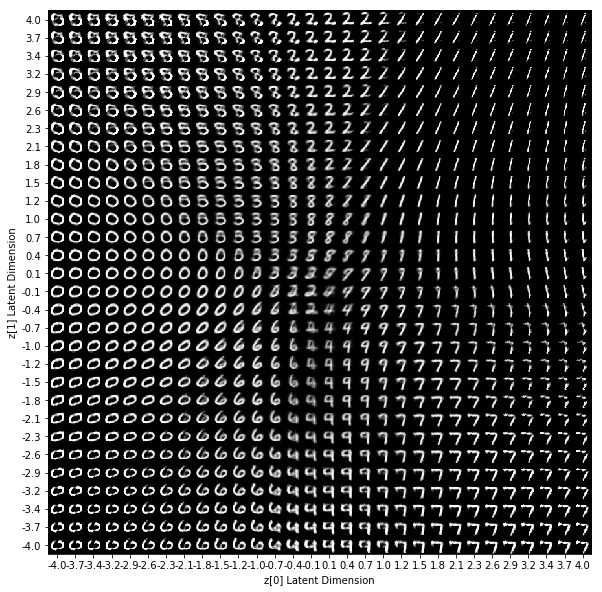

In [21]:
generate_manifold(decoder)

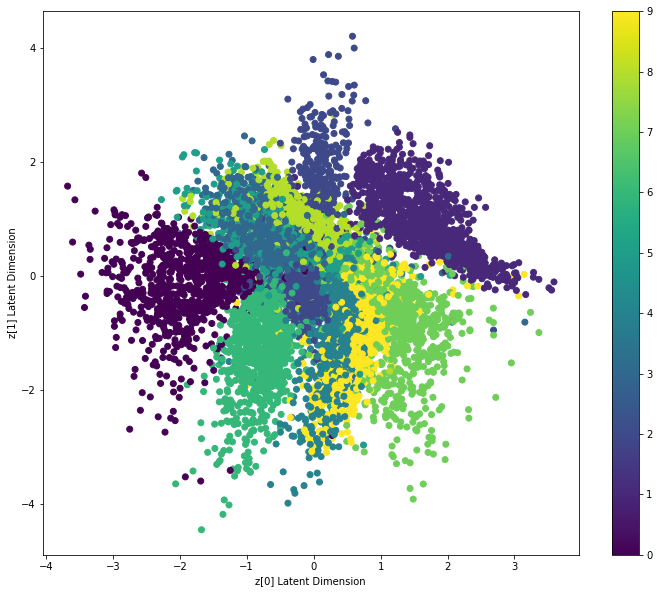

In [22]:
plot_digits(X_test, y, encoder)  # y for label coloring

Looks like by using the decoder on noisy data we can generate a completely new data! Now how amazing is that? <3.
But this is an image data so the question we have in our mind that would it possible to use with convolutions so we can get better results? Of course! Now let's try convolution version of VAE.

## Convolutional VAE

Although, we don't use maxpooling in our model, feel free to use it when you want to test and see if it helps(both for decreasing amount of trainable parameters and faster training.)

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1560252253/1-s2.0-S0009250918300460-gr3.jpg" width="900" height="600">

In [31]:
# new network parameters
input_shape = (28, 28, 1)
batch_size = 128
filters = 32
latent_dim = 2
epochs = 30

**Encoder**

In [43]:
inputs = kr.Input(shape=input_shape, name='input')

x = kr.layers.Conv2D(filters, (3, 3), activation='relu', strides=2, padding='same')(inputs)
x = kr.layers.Conv2D(filters*2, (3, 3), activation='relu', strides=2, padding='same')(x)

# shape info needed to build decoder model
shape = x.get_shape().as_list()

# generate latent vector Q(z|X)
x = kr.layers.Flatten()(x)
x = kr.layers.Dense(16, activation='relu')(x)
z_mean = kr.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = kr.layers.Dense(latent_dim, name='z_log_var')(x)

z = kr.layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = kr.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 32)   320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_10[0][0]                  
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3136)         0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
dense_18 (

**Decoder**

In [44]:
# build decoder model
latent_inputs = kr.Input(shape=(latent_dim,), name='z_sampling')
x = kr.layers.Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = kr.layers.Reshape((shape[1], shape[2], shape[3]))(x)
x = kr.layers.Conv2DTranspose(filters*2, (3, 3), activation='relu', strides=2, padding='same')(x)
x = kr.layers.Conv2DTranspose(filters, (3, 3), activation='relu', strides=2, padding='same')(x)
outputs = kr.layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)

# instantiate decoder model
decoder = kr.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_________________________________________________________________


In [45]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = kr.Model(inputs, outputs, name='vae')

In [46]:
# Reconstruction loss
reconstruction_loss = tf.losses.mean_squared_error(inputs, outputs)
reconstruction_loss = reconstruction_loss * num_features

# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 69076     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         65089     
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


In [47]:
X_train, X_test = X_train.reshape([-1, 28, 28, 1]), X_test.reshape([-1, 28, 28, 1])
vae.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 5s 90us/sample - loss: 57.1817 - val_loss: 49.1010
Epoch 2/30
60000/60000 [==============================] - 4s 68us/sample - loss: 46.5302 - val_loss: 44.6445
Epoch 3/30
60000/60000 [==============================] - 4s 67us/sample - loss: 44.1632 - val_loss: 43.3530
Epoch 4/30
60000/60000 [==============================] - 4s 67us/sample - loss: 43.0041 - val_loss: 42.4166
Epoch 5/30
60000/60000 [==============================] - 4s 67us/sample - loss: 42.2197 - val_loss: 41.5058
Epoch 6/30
60000/60000 [==============================] - 4s 67us/sample - loss: 41.6179 - val_loss: 41.0642
Epoch 7/30
60000/60000 [==============================] - 4s 67us/sample - loss: 41.1512 - val_loss: 40.7813
Epoch 8/30
60000/60000 [==============================] - 4s 67us/sample - loss: 40.7702 - val_loss: 40.5484
Epoch 9/30
60000/60000 [==============================] - 4s 66us/sample - los

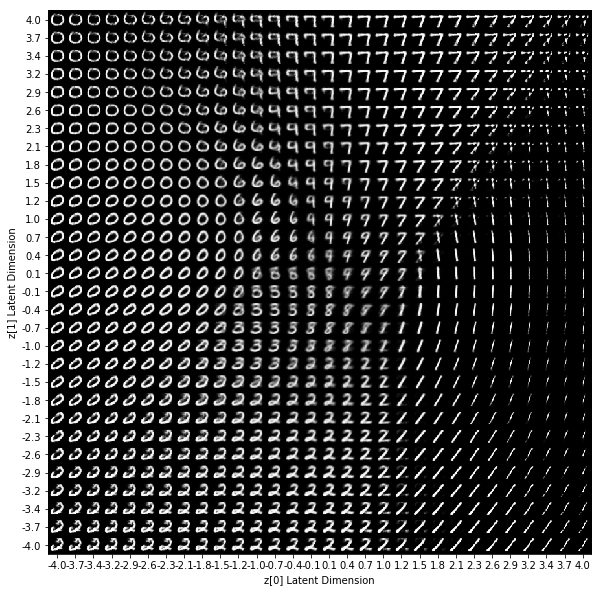

In [48]:
generate_manifold(decoder)

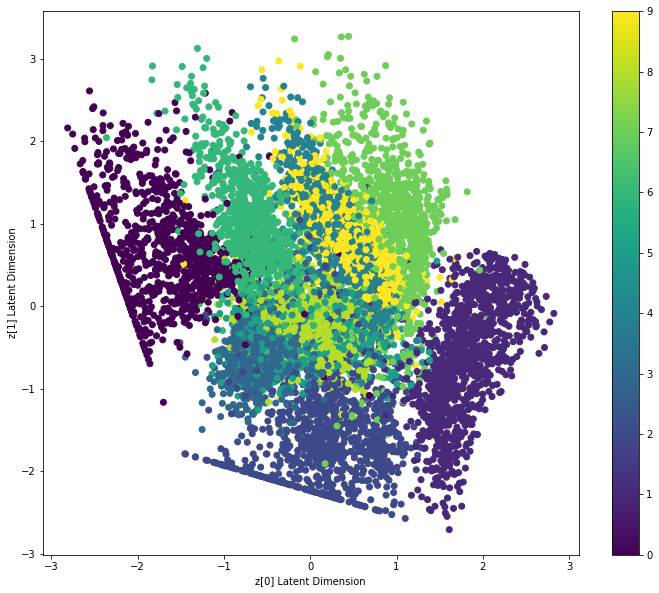

In [49]:
plot_digits(X_test, y, encoder)

## Conclusions
By changing the size of filters or layers, it's possible to get much more better results.